# 1. Import Library

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')

# 2. Prepare Data

In [ ]:
!unzip /kaggle/input/dogs-vs-cats/train.zip

In [ ]:
!unzip /kaggle/input/dogs-vs-cats/test1.zip

# 3. Create Path


In [4]:
path , dirs , files = next(os.walk('/kaggle/working/train'))
file_count = len(files)
print(file_count)
base_dir = '/kaggle/working/dogs_vs_cats_small'
os.mkdir(base_dir)

25000


# 4. Create Directories for Train , Test and Validation Data


In [5]:
train_dir = os.path.join(base_dir , 'train')
os.mkdir(train_dir) #make a new train directory inside my base directory

valid_dir= os.path.join(base_dir , 'validation')
os.mkdir(valid_dir) #make a new validation directory inside my base directory

test_dir = os.path.join(base_dir , 'test')
os.mkdir(test_dir) #make a new test directory inside my base directory

train_cats_dir = os.path.join(train_dir , 'cats')
os.mkdir(train_cats_dir) #make a new cats directory inside my train directory

train_dogs_dir = os.path.join(train_dir , 'dogs')
os.mkdir(train_dogs_dir) #make a new dogs directory inside my train directory

valid_cats_dir = os.path.join(valid_dir, 'cats')
os.mkdir(valid_cats_dir) #make a new cats directory inside my validation directory

valid_dogs_dir = os.path.join(valid_dir , 'dogs')
os.mkdir(valid_dogs_dir) #make a new dogs directory inside my validation directory

test_cats_dir = os.path.join(test_dir , 'cats')
os.mkdir(test_cats_dir) #make a new cats directory inside my test directory

test_dogs_dir = os.path.join(test_dir , 'dogs')
os.mkdir(test_dogs_dir) #make a new dogs directory inside my test directory

In [6]:
dir_path = '/kaggle/working/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1
        
print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")

Number of cat images: 12500
Number of dog images: 12500


# 5. Separate Train, Test and Validation Data

In [7]:
original_dataset_dir = '/kaggle/working/train'

# Create lists of file names for cat images in each set
fnames = ['cat.{}.jpg'.format(i) for i in range(10001)]  # Move 10,000 cat images to the train cat directory
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(10001, 11251)]  # Move 1250 cat images to the validation cat directory
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(11251, 12500)]  # Move 1250 cat images to the test cat directory
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Create lists of file names for dog images in each set
fnames = ['dog.{}.jpg'.format(i) for i in range(10001)]  # Move 10,000 dog images to the train dog directory
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001, 11251)]  # Move 1250 dog images to the validation dog directory
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(11251, 12500)]  # Move 1250 dog images to the test dog directory
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [9]:
print(f'Total training cat images {len(os.listdir(train_cats_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_cats_dir))}')
print(f'Total test cat images {len(os.listdir(test_cats_dir))}')
print('\n')
print(f'Total training dog images {len(os.listdir(train_dogs_dir))}')
print(f'Total validation cat images {len(os.listdir(valid_dogs_dir))}')
print(f'Total test cat images {len(os.listdir(test_dogs_dir))}')

Total training cat images 10001
Total validation cat images 1250
Total test cat images 1249


Total training dog images 10001
Total validation cat images 1250
Total test cat images 1249


In [10]:
img_size = (224 , 224)
batch_size = 32
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(valid_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'binary' , 
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 20002 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


# 6. View Sample Images

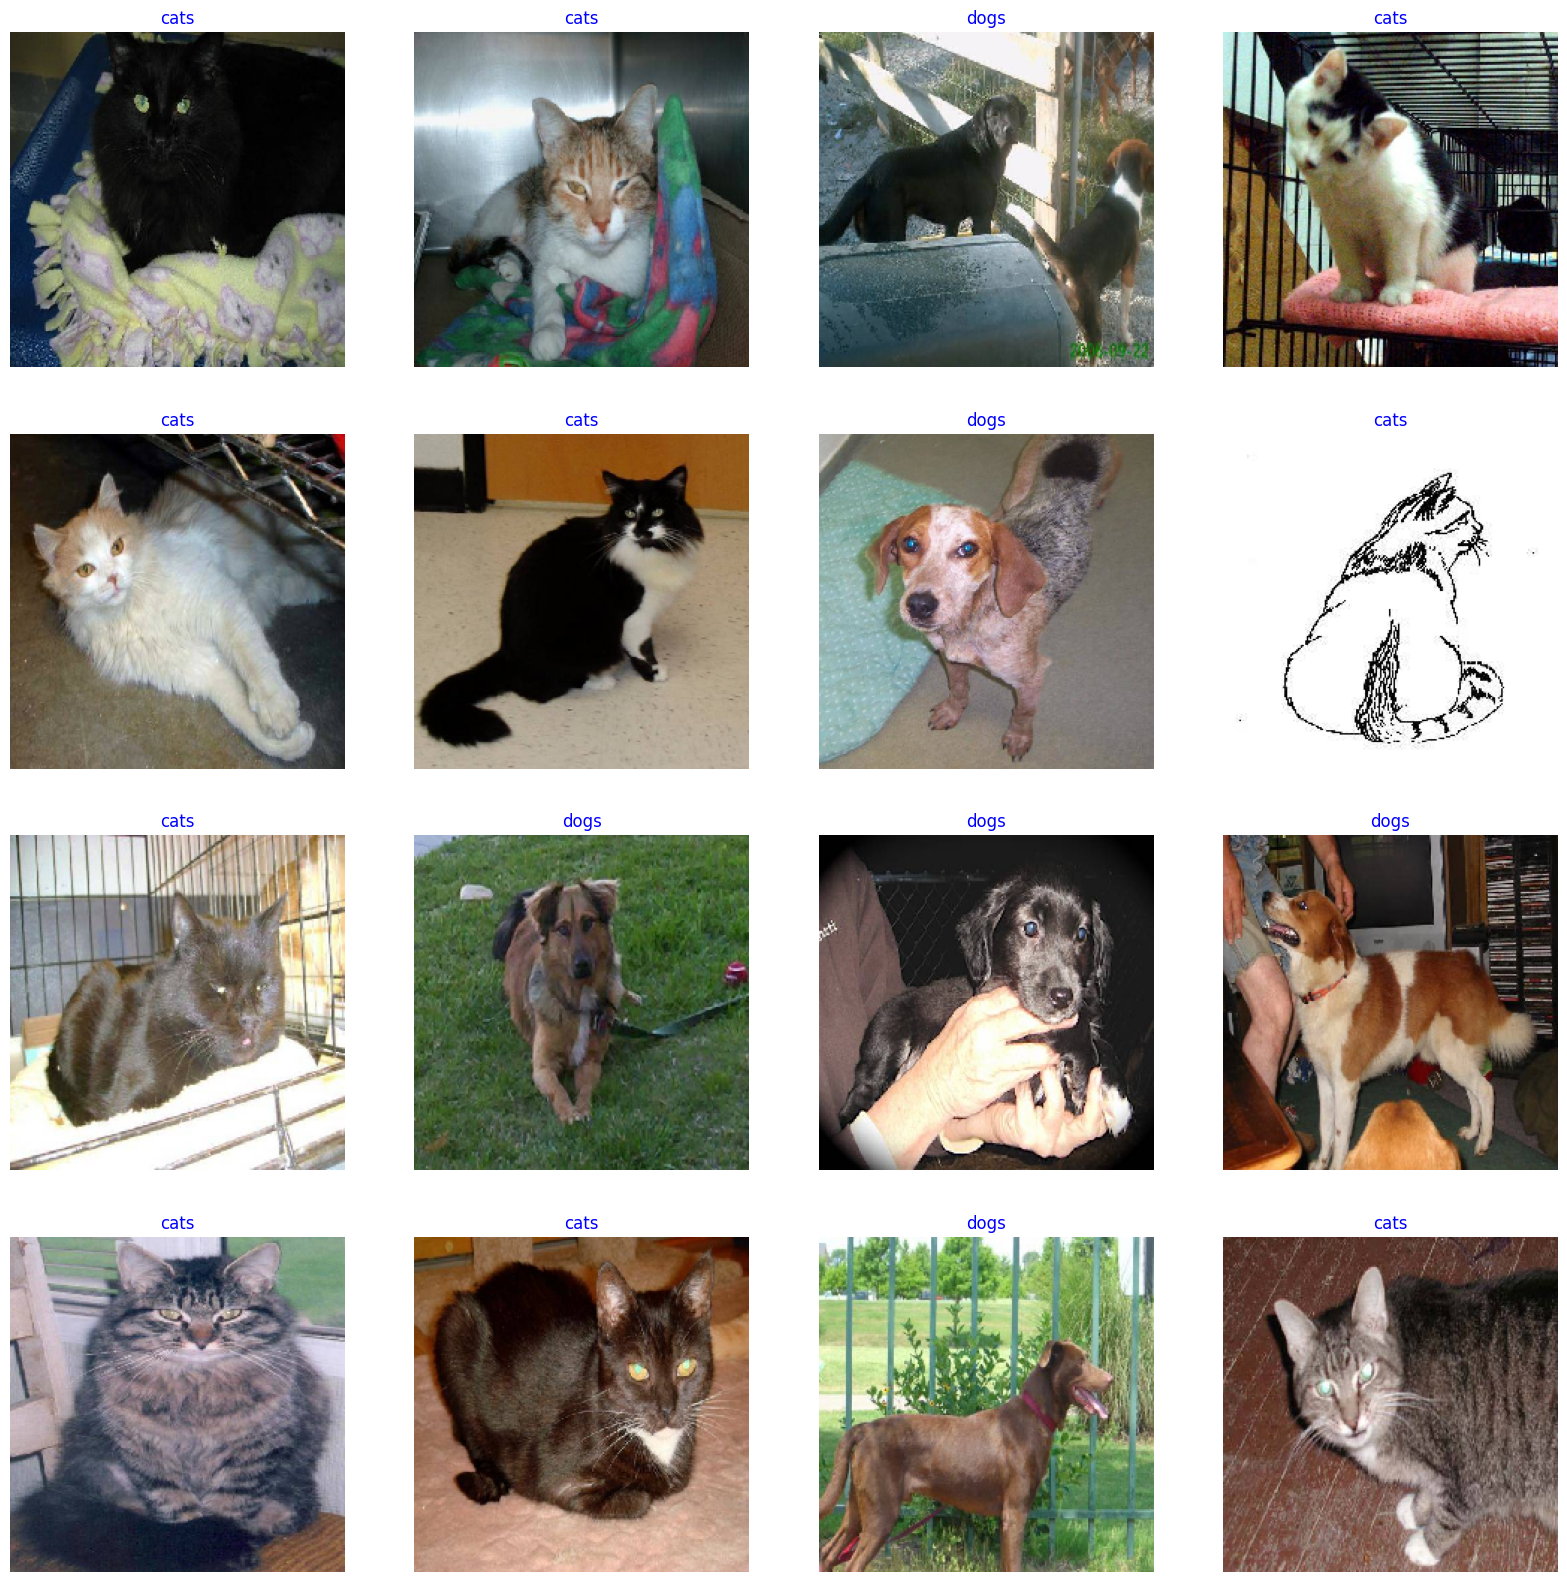

In [11]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = int(labels[i])
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

# 7. Build Model

In [12]:
img_shape = (img_size[0], img_size[1], 3)

# Load pre-trained EfficientNetB5 without the top (fully connected) layers
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

# Freeze the weights of the pre-trained layers
base_model.trainable = False

# Number of classes (binary classification in this case)
num_classes = len(classes)

# Build the model using Sequential API
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=40),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

115263384/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                       

# 8. Fit Model

In [14]:
history = model.fit(x= train_gen , validation_data= valid_gen , epochs= 10 , verbose = 1 , validation_steps = None , shuffle = False)

Epoch 1/10
626/626 [==============================] - 96s 153ms/step - loss: 0.1117 - accuracy: 0.9881 - val_loss: 0.1059 - val_accuracy: 0.9848
Epoch 2/10
626/626 [==============================] - 96s 153ms/step - loss: 0.1063 - accuracy: 0.9893 - val_loss: 0.1034 - val_accuracy: 0.9880
Epoch 3/10
626/626 [==============================] - 96s 154ms/step - loss: 0.1053 - accuracy: 0.9891 - val_loss: 0.1059 - val_accuracy: 0.9864
Epoch 4/10
626/626 [==============================] - 97s 154ms/step - loss: 0.1056 - accuracy: 0.9878 - val_loss: 0.1012 - val_accuracy: 0.9876
Epoch 5/10
626/626 [==============================] - 96s 154ms/step - loss: 0.1038 - accuracy: 0.9890 - val_loss: 0.1009 - val_accuracy: 0.9864
Epoch 6/10
626/626 [==============================] - 96s 153ms/step - loss: 0.1047 - accuracy: 0.9876 - val_loss: 0.1030 - val_accuracy: 0.9856
Epoch 7/10
626/626 [==============================] - 96s 153ms/step - loss: 0.1002 - accuracy: 0.9888 - val_loss: 0.0974 - val_ac

# 9. Train Vs. Validation Accuracy

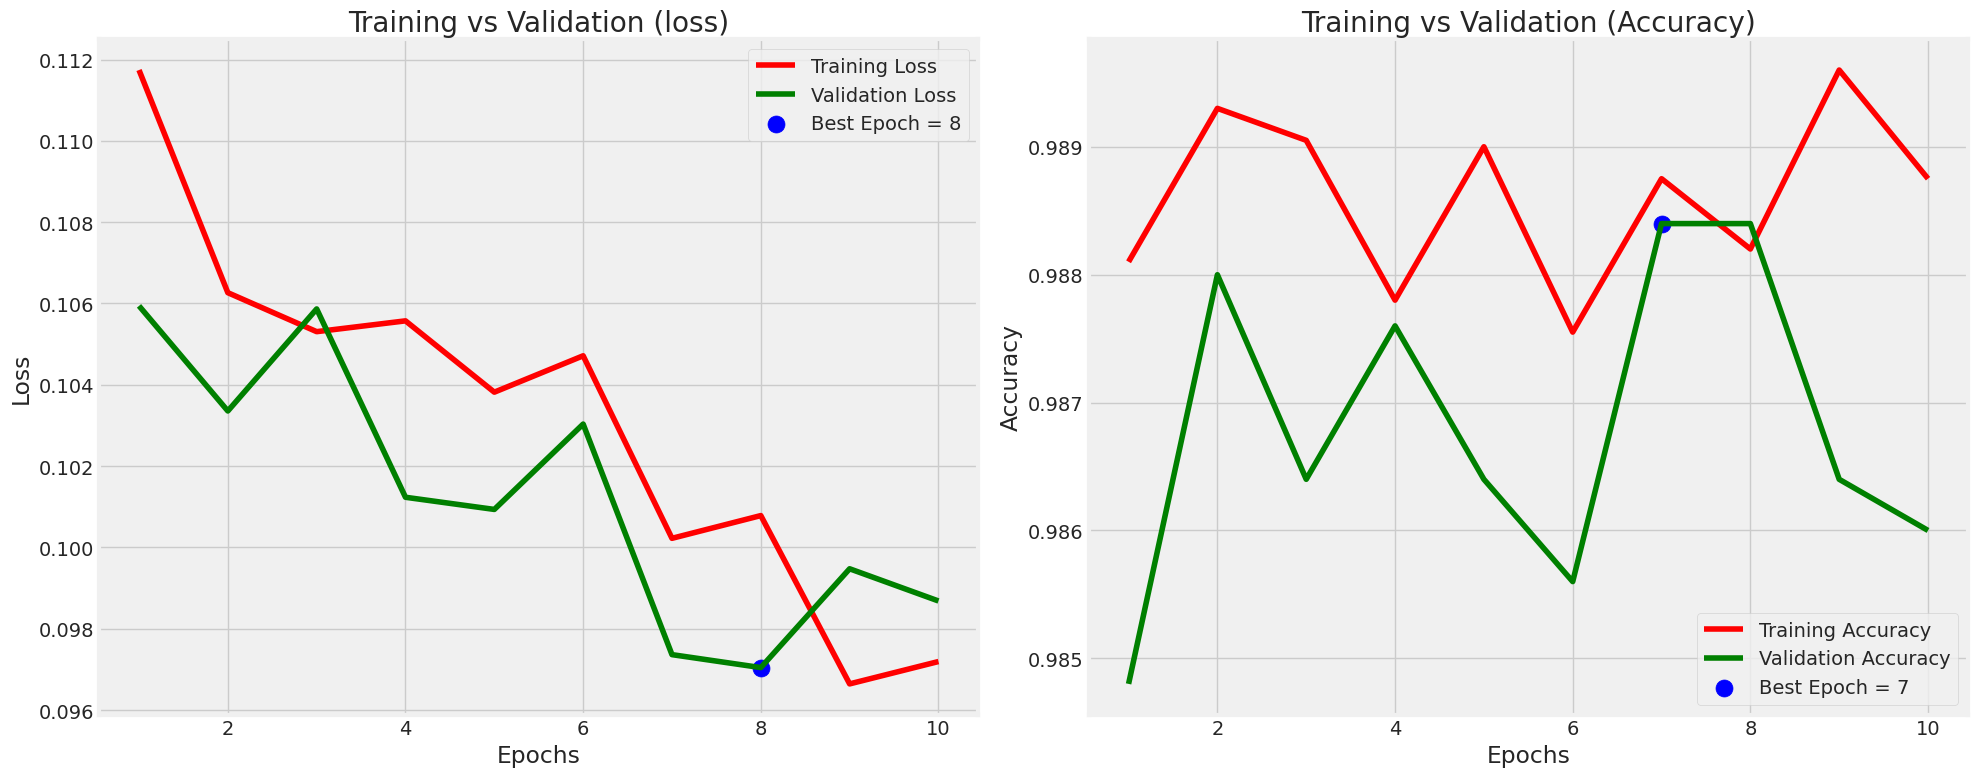

In [15]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 10. Evaluate Model

In [16]:
train_score = model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 [==============================] - 4s 127ms/step - loss: 0.0857 - accuracy: 0.9912
Train loss = 0.06653103232383728
Train Accuracy = 0.9990234375
Validation loss = 0.09732069820165634
Validation Accuracy = 0.9873046875
Test loss = 0.08568117022514343
Test Accuracy = 0.9912109375


# 11. Make Predictions

In [17]:
# Make predictions on the test set
preds = model.predict(test_gen)

# Convert the predictions to binary classes (0 or 1)
predicted_classes = (preds > 0.5).astype(int)

79/79 [==============================] - 14s 128ms/step


# 12. View prediction Result


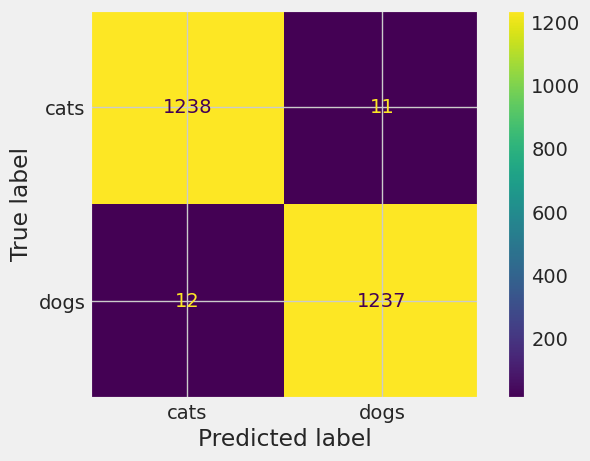

In [18]:
# Get the true labels from the generator
true_classes = test_gen.classes

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=test_gen.class_indices)
disp.plot(cmap='viridis', values_format='d')

In [19]:
# Generate and print the classification report
classification_rep = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1249
        dogs       0.99      0.99      0.99      1249

    accuracy                           0.99      2498
   macro avg       0.99      0.99      0.99      2498
weighted avg       0.99      0.99      0.99      2498

